# Figure showing emergence times of Arctic OLR with confidence intervals

Calculate emergence using the Weatherhead-Shaw approach. When letting the forced response evolve (time dependence), emergence differences between the Weatherhead and Leroy estimates of $\tau_{var}$ were minor. We use the Weatherhead method because it also works for short observational periods.

## Load Data

### Do imports

In [3]:
import sys

sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.

from imports import (
    np, xr, plt, sns, os, 
    glob,
    dask
    )

from functions import (
    to_png,
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Methods

#### Weatherhead et al. (1998)

$$ n^* \approx \left[ \frac{3.3 \sigma_{\epsilon}}{|\omega_0|(1-\phi)} \right] ^{2/3} = \left[ \frac{3.3 \sigma_{N}}{|\omega_0|} \sqrt{\frac{1+\phi}{1 - \phi}} \right] ^{2/3}, $$

Reformulation from Phojan et al. (2014):

$$ [\textrm{Var}(\hat{m})]^{1/2} \approx \left[ \frac{12}{T^3} \textrm{Var}(N_t) \tau_{W}  \right]^{1/2}, $$

where $N_t$ is the demeaned and detrended timeseries and $\tau_W$ is the Weatherhead correlation time given by

$$ \tau_W = \frac{1 + \phi}{1 - \phi}. $$

Time-to-emergence $\Delta t$. Emergence has occured if the length of the record exceeds the time-to-emergence.

$$ \Delta t = \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{W} \right]^{1/3}, $$

We will use the expression from Phojanamongkolkij (2014) because it is effectively the same as Leroy with a different expression for the correlation time. We take the lag-1 autocorrelation of the noise (taken from the PI-Control simulation), and the measured noise $\sigma_N$ (taken from the PI-Control simulation).

### Load pre-processed variability and trends

Pre-processing from timeseries to variability and trends is done in OLRemergence_temporal_preproc2.ipynb.

In [52]:
# Load variability

variability_day1_ds   = xr.open_dataset('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_daily_20230417.nc')

variability_day5_ds   = xr.open_dataset('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_day5_20230417.nc')

variability_day15_ds  = xr.open_dataset('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_day15_20230417.nc')

variability_month1_ds = xr.open_dataset('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_20220109.nc')


In [17]:
# Load trends

trends_day1_ds = xr.open_dataset('/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticMemberTrends/CESM1LEArcticTrends_day1.nc')

trends_day5_ds = xr.open_dataset('/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticMemberTrends/CESM1LEArcticTrends_day5.nc')

trends_day15_ds = xr.open_dataset('/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticMemberTrends/CESM1LEArcticTrends_day15.nc')

trends_month1_ds = xr.open_dataset('/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticMemberTrends/CESM1LEArcticTrends_month1.nc')

#### 3. Use the Weatherhead/Leroy/Phojanamongkolkij approach to calculate time-to-emergence for each ensemble member

Emergence occurs when the climate signal exits internal variability for the LAST time.

__More extensive code in fig6_OLRemergence_full.ipynb__ I do a comparison between Leroy and Weatherhead there.

In [19]:
emerge_vars = ['FLUT','TS','ICEFRAC','FSNTOA']

Calculate predicted time-to-emergence 

In [45]:
# TTE_W_all  = {}

# s = 2

# trend_data       = trends_day15_ds
# variability_data = variability_day15_ds

# # Using Weatherhead here. Best when the memory is small, which is true for all OLR fields
# # I need to iterate because the variability datasets are not indexed the same as
# # the trends, so they don't broadcast together perfectly.
# for _var in emerge_vars:
#     _stddevs   = variability_data.sel(variable=_var)['stddev']
#     _tauvars_W = variability_data.sel(variable=_var)['tauvar_Wea']
#     _slopes    = trend_data[_var]
    
#     # time calculated using a correlation time from the lag-1 method 
#     _TTE_W  = (12*s**2 * _stddevs**2 * _tauvars_W / _slopes**2)**(1/3)
#     _TTE_W.name = _var
#     _TTE_W = _TTE_W.drop('variable')
#     # _TTE_W  = (12*s**2 * _stddevs[_var]**2 * _tauvars_W[_var] / _slopes[_var]**2)**(1/3)
    
#     TTE_W_all[_var]  = _TTE_W

# TTE_W_day15 = xr.merge(TTE_W_all.values())

In [46]:
def calc_TTE_from_preproc(varlist,trend_data,variability_data,s=2):
    
    TTE_W_all  = {}
    
    for _var in varlist:
        _stddevs   = variability_data.sel(variable=_var)['stddev']
        _tauvars_W = variability_data.sel(variable=_var)['tauvar_Wea']
        _slopes    = trend_data[_var]

        # time calculated using a correlation time from the lag-1 method 
        _TTE_W  = (12*s**2 * _stddevs**2 * _tauvars_W / _slopes**2)**(1/3)
        _TTE_W.name = _var
        _TTE_W = _TTE_W.drop('variable')

        TTE_W_all[_var]  = _TTE_W

    return xr.merge(TTE_W_all.values())

In [54]:
TTE_W_day1   = calc_TTE_from_preproc(emerge_vars,trend_data=trends_day1_ds,variability_data=variability_day1_ds)

TTE_W_day5   = calc_TTE_from_preproc(emerge_vars,trend_data=trends_day5_ds,variability_data=variability_day5_ds)

TTE_W_day15  = calc_TTE_from_preproc(emerge_vars,trend_data=trends_day15_ds,variability_data=variability_day15_ds)

TTE_W_month1 = calc_TTE_from_preproc(emerge_vars,trend_data=trends_month1_ds,variability_data=variability_month1_ds)

__Translate to an emergence time (when the signal exits internal variability for the last time).__

In [62]:
def emergence_wrapper(TTE_data,dim='duration'):
    detect_ds = TTE_data < TTE_data.duration
    duration_broad = detect_ds.duration.broadcast_like(detect_ds)
    
    emergence_ds = 1 + duration_broad.where(~detect_ds).max(dim=dim)
    
    return emergence_ds

In [66]:
# Map the function across all variables.

emergence_W_day1   = TTE_W_day1.map(emergence_wrapper,dim='endyear')
emergence_W_day5   = TTE_W_day5.map(emergence_wrapper,dim='endyear')
emergence_W_day15  = TTE_W_day15.map(emergence_wrapper,dim='endyear')

emergence_W_month1 = TTE_W_month1.map(emergence_wrapper,dim='duration')

__Add asymmetry and use bootstrapping to limit the effect outliers.__

_Weatherhead estimates bootstrapped -->_

In [103]:
def bootstrap_CIs(data_ds,
                  nbootstraps=3000,
                  alpha=0.95,
                  axis=1,
                  coords_dict=dict(
                      # bound=[lower_bound,50,upper_bound], # bounds are percentiles now
                      month=np.arange(1,14,1),
                  )
                 ):
    
    N_ens = len(data_ds['ens']) # number of members
    gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array

    # Compute percentiles using bootstrapping
    lower_percentile = []
    upper_percentile = []
    mean_emergence = []

    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 1)
        resample_emergence = gen.choice(data_ds, size=N_ens, replace=True,axis=axis)
        # compute percentiles along the ensemble dimension (axis 1)
        lower_percentile.append(np.percentile(resample_emergence,lower_bound,axis=axis))
        upper_percentile.append(np.percentile(resample_emergence,upper_bound,axis=axis))
        mean_emergence.append(np.mean(resample_emergence,axis=axis))

    _lower_emerge_bstrap = np.mean(lower_percentile,axis=0) # take the mean percentile along the correct axis
    _upper_emerge_bstrap = np.mean(upper_percentile,axis=0)
    _mean_emerge_bstrap  = np.mean(mean_emergence,axis=0)

    time_coord = list(coords_dict.keys())[0]
    coords_dict['bound'] = [lower_bound,50,upper_bound]

    _emergence_LP_da = xr.DataArray(
        data=np.array([_lower_emerge_bstrap,_mean_emerge_bstrap,_upper_emerge_bstrap]),
        dims=["bound",time_coord],
        coords=coords_dict,
        # name = _var
    )
    
    # _emergence_LP_da = xr.DataArray(
    #     data=np.array([_lower_emerge_bstrap,_mean_emerge_bstrap,_upper_emerge_bstrap]),
    #     dims=["bound","month"],
    #     coords=dict(
    #         bound=[lower_bound,50,upper_bound], # bounds are percentiles now
    #         month=np.arange(1,14,1),
    #     ),
    #     # name = _var
    # )
    
    return _emergence_LP_da

In [91]:
emergence_W_day15

<xarray.Dataset>
Dimensions:    (dayofyear: 24, ens: 40)
Coordinates:
  * dayofyear  (dayofyear) int64 8 23 38 53 68 83 98 ... 278 293 308 323 338 353
  * ens        (ens) int64 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 101 102 103 104 105
Data variables:
    FLUT       (dayofyear, ens) float64 35.0 31.0 39.0 33.0 ... 19.0 31.0 31.0
    TS         (dayofyear, ens) float64 34.0 29.0 23.0 19.0 ... 15.0 20.0 28.0
    ICEFRAC    (dayofyear, ens) float64 43.0 28.0 44.0 38.0 ... 19.0 21.0 30.0
    FSNTOA     (dayofyear, ens) float64 81.0 81.0 81.0 81.0 ... 81.0 81.0 81.0

In [113]:
%time

# Bootstrap 95% confidence intervals

# These dictionaries tell the function how to organize the output after bootstrapping.
day1_coords_dict = dict(dayofyear=emergence_W_day1['dayofyear'],
                       )

day5_coords_dict = dict(dayofyear=emergence_W_day5['dayofyear'],
                       )

day15_coords_dict = dict(dayofyear=emergence_W_day15['dayofyear'],
                        )

# What day of the year is the 15th day of each month? Last (366) is for annual avg.
dayofyear_middlemonth = [15,46,74,105,135,166,196,227,258,288,319,349,366] 
month1_coords_dict = dict(dayofyear=dayofyear_middlemonth, 
                         )

emergence_W_CI_day1   = emergence_W_day1.map(bootstrap_CIs,coords_dict=day1_coords_dict)

emergence_W_CI_day5   = emergence_W_day5.map(bootstrap_CIs,coords_dict=day5_coords_dict)

emergence_W_CI_day15  = emergence_W_day15.map(bootstrap_CIs,coords_dict=day15_coords_dict)

emergence_W_CI_month1 = emergence_W_month1.map(bootstrap_CIs,coords_dict=month1_coords_dict)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


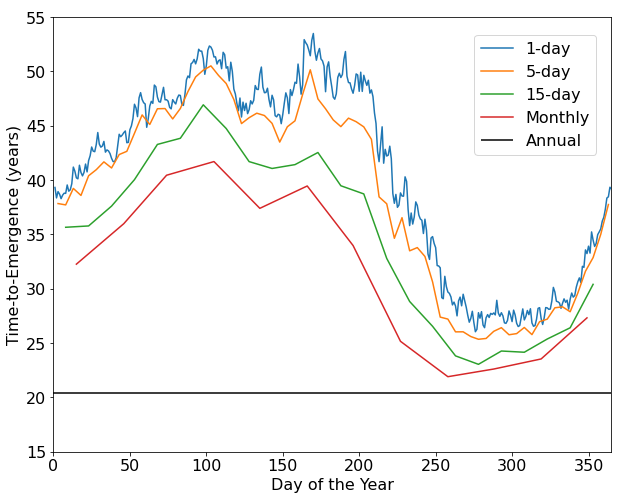

In [142]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

plt.plot(emergence_W_CI_day1['dayofyear'],emergence_W_CI_day1['FLUT'].sel(bound=50),
         label='1-day',
        )

plt.plot(emergence_W_CI_day5['dayofyear'],emergence_W_CI_day5['FLUT'].sel(bound=50),
         label='5-day',
        )

plt.plot(emergence_W_CI_day15['dayofyear'],emergence_W_CI_day15['FLUT'].sel(bound=50),
         label='15-day',
        )

plt.plot(emergence_W_CI_month1['dayofyear'][:12],emergence_W_CI_month1['FLUT'].sel(bound=50)[:12],
         label='Monthly',
        )


plt.hlines(y=emergence_W_CI_month1['FLUT'].sel(bound=50)[-1],xmin=0,xmax=365,
          color='black',
          label='Annual'
          )

ax.set_xlim(0,365)
ax.set_ylim(15,55)

ax.set_xlabel('Day of the Year',fontsize=16)
ax.set_ylabel('Time-to-Emergence (years)',fontsize=16)

ax.tick_params(axis='both',labelsize=16)

fig.legend(loc=(0.75,0.69),fontsize=16)


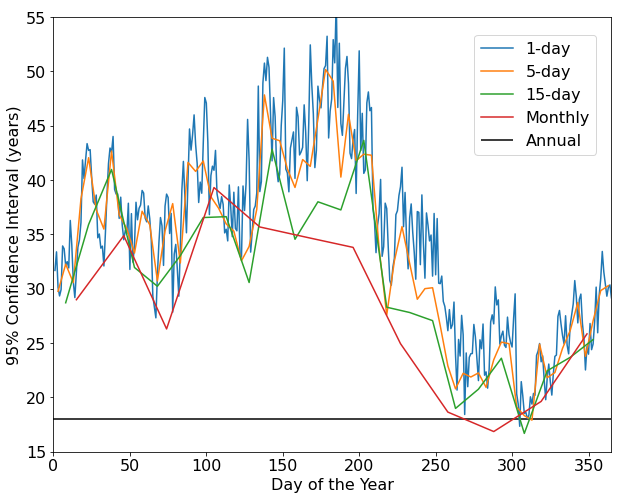

In [146]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

# Calculate the width of the CIs
day1_FLUT_CI   = emergence_W_CI_day1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day1['FLUT'].sel(bound=2.5,method='nearest')
day5_FLUT_CI   = emergence_W_CI_day5['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day5['FLUT'].sel(bound=2.5,method='nearest')
day15_FLUT_CI  = emergence_W_CI_day15['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day15['FLUT'].sel(bound=2.5,method='nearest')
month1_FLUT_CI = emergence_W_CI_month1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_month1['FLUT'].sel(bound=2.5,method='nearest')
year1_FLUT_CI  = month1_FLUT_CI[-1]

plt.plot(emergence_W_CI_day1['dayofyear'],day1_FLUT_CI,
         label='1-day',
        )

plt.plot(emergence_W_CI_day5['dayofyear'],day5_FLUT_CI,
         label='5-day',
        )

plt.plot(emergence_W_CI_day15['dayofyear'],day15_FLUT_CI,
         label='15-day',
        )

plt.plot(emergence_W_CI_month1['dayofyear'][:12],month1_FLUT_CI[:12],
         label='Monthly',
        )

plt.hlines(y=year1_FLUT_CI,xmin=0,xmax=365,
          color='black',
          label='Annual'
          )

ax.set_xlim(0,365)
ax.set_ylim(15,55)

ax.set_xlabel('Day of the Year',fontsize=16)
ax.set_ylabel('95% Confidence Interval (years)',fontsize=16)

ax.tick_params(axis='both',labelsize=16)

fig.legend(loc=(0.75,0.69),fontsize=16)


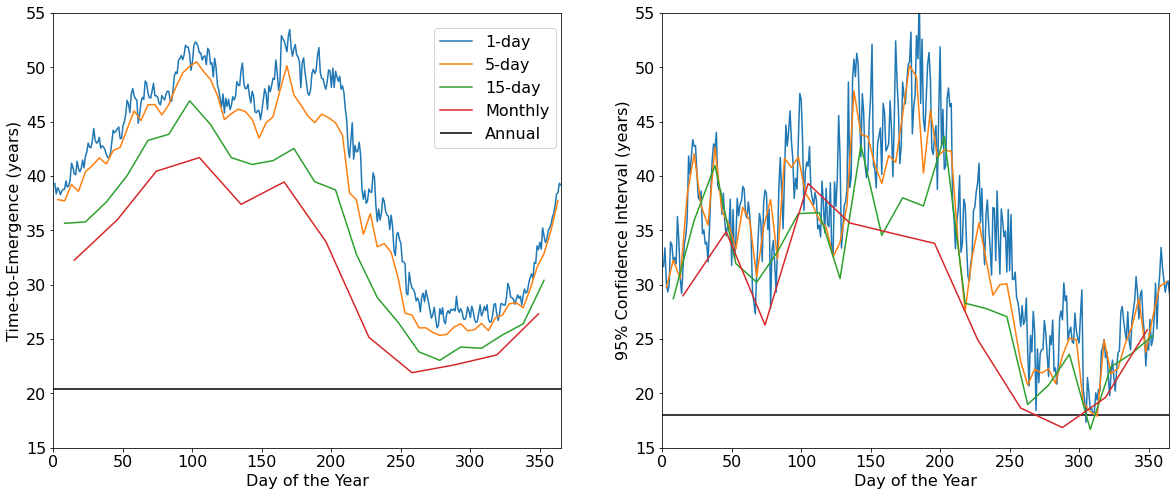

In [151]:
fig,ax = plt.subplots(1,2,figsize=(20,8))

# Calculate the width of the CIs
day1_FLUT_CI   = emergence_W_CI_day1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day1['FLUT'].sel(bound=2.5,method='nearest')
day5_FLUT_CI   = emergence_W_CI_day5['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day5['FLUT'].sel(bound=2.5,method='nearest')
day15_FLUT_CI  = emergence_W_CI_day15['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day15['FLUT'].sel(bound=2.5,method='nearest')
month1_FLUT_CI = emergence_W_CI_month1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_month1['FLUT'].sel(bound=2.5,method='nearest')
year1_FLUT_CI  = month1_FLUT_CI[-1]

# Plot the Mean TTE
ax[0].plot(emergence_W_CI_day1['dayofyear'],emergence_W_CI_day1['FLUT'].sel(bound=50),
           label='1-day',
          )

ax[0].plot(emergence_W_CI_day5['dayofyear'],emergence_W_CI_day5['FLUT'].sel(bound=50),
           label='5-day',
          )

ax[0].plot(emergence_W_CI_day15['dayofyear'],emergence_W_CI_day15['FLUT'].sel(bound=50),
           label='15-day',
          )

ax[0].plot(emergence_W_CI_month1['dayofyear'][:12],emergence_W_CI_month1['FLUT'].sel(bound=50)[:12],
           label='Monthly',
          )


ax[0].hlines(y=emergence_W_CI_month1['FLUT'].sel(bound=50)[-1],xmin=0,xmax=365,
            color='black',
            label='Annual'
            )

# Plot the width of the CIs
ax[1].plot(emergence_W_CI_day1['dayofyear'],day1_FLUT_CI,
           label='1-day',
          )

ax[1].plot(emergence_W_CI_day5['dayofyear'],day5_FLUT_CI,
           label='5-day',
          )

ax[1].plot(emergence_W_CI_day15['dayofyear'],day15_FLUT_CI,
           label='15-day',
          )

ax[1].plot(emergence_W_CI_month1['dayofyear'][:12],month1_FLUT_CI[:12],
           label='Monthly',
          )

ax[1].hlines(y=year1_FLUT_CI,xmin=0,xmax=365,
             color='black',
             label='Annual'
            )

ax[0].set_xlim(0,365)
ax[0].set_ylim(15,55)

ax[0].set_xlabel('Day of the Year',fontsize=16)
ax[0].set_ylabel('Time-to-Emergence (years)',fontsize=16)

ax[1].set_xlim(0,365)
ax[1].set_ylim(15,55)

ax[1].set_xlabel('Day of the Year',fontsize=16)
ax[1].set_ylabel('95% Confidence Interval (years)',fontsize=16)

ax[0].tick_params(axis='both',labelsize=16)
ax[1].tick_params(axis='both',labelsize=16)

ax[0].legend(loc=(0.75,0.69),fontsize=16)


In [154]:
to_png(fig,filename='OLR_emergence_temporalscales',dpi=300,ext='pdf',bbox_inches='tight')

- When there is less variability, you reach the averaging floor more quickly. We can see that the monthly averages are always lower than the 15-day averages, but in September they start to get close together.

- Averaging reduces the average TTE. But the 95% confidence interval is pretty constant. I'd expect a much larger 95% confidence interval with the higher frequency data, but I guess that's not the case.